In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
df_raw = pd.read_csv("annthyroid.csv", header=None)
df_raw.loc[df_raw[21] == -1, 21] = 0
device = "cpu"
y = pd.get_dummies(df_raw.iloc[:,-1])
y = torch.Tensor(y.values).to(device)
x = df_raw.iloc[:,:-1]
x = torch.Tensor(x.values).to(device)
num_split = int(len(x) * 0.8)
print(num_split)
x_train = x[:num_split,:]
x_test = x[num_split:,:]
y_train = y[:num_split,:]
y_test = y[num_split:,:]

5672


In [3]:
df_raw[21].value_counts()

1    6563
0     527
Name: 21, dtype: int64

In [4]:
x_train_p_list = []
y_train_p_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([0.,1.])):
        #print("c")
        x_train_p_list.append(x_train[i])
        y_train_p_list.append(y_train[i])
#print(x_train_M_list)
y_train_p = torch.stack(y_train_p_list)
x_train_p = torch.stack(x_train_p_list)
x_train_n_list = []
y_train_n_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([1.,0.])):
        #print("c")
        x_train_n_list.append(x_train[i])
        y_train_n_list.append(y_train[i])
#print(x_train_M_list)
y_train_n = torch.stack(y_train_n_list)
x_train_n = torch.stack(x_train_n_list)
print(len(x_train_p))
print(len(x_train_n))

5243
429


In [5]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=8, num_dim=21):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=512)
        self.encoder_layer_2 = nn.Linear(in_features=512, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=512)
        self.decoder_layer_2 = nn.Linear(in_features=512, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var
    
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]
    
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [6]:
num_features = 8
model = VariationalAutoencoder(num_features=num_features)
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 1000

In [7]:
custom_dataset_x_train_n = AutoencoderDataset(x_train_n)

train_loader = DataLoader(
    custom_dataset_x_train_n,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [8]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "variational-autoencoder_annthyroid_n.pth")

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s, loss=109]


Ave Loss: 109.31758880615234
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=38.4]


Ave Loss: 38.35467529296875
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.03it/s, loss=18.1]


Ave Loss: 18.10736656188965
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=18.7]


Ave Loss: 18.703580856323242
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.49it/s, loss=21.8]


Ave Loss: 21.842275619506836
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.47it/s, loss=23.7]


Ave Loss: 23.744199752807617
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=23.9]


Ave Loss: 23.942838668823242
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.01it/s, loss=22.8]


Ave Loss: 22.773967742919922
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=20.2]


Ave Loss: 20.229694366455078
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=16.1]


Ave Loss: 16.133460998535156
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=11.1]


Ave Loss: 11.101045608520508
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=6.66]


Ave Loss: 6.662525177001953
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=4.35]


Ave Loss: 4.350823402404785
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.37it/s, loss=4.63]


Ave Loss: 4.632349967956543
Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.47it/s, loss=6.65]


Ave Loss: 6.653548240661621
Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.47it/s, loss=8.83]


Ave Loss: 8.82532024383545
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=9.85]


Ave Loss: 9.849165916442871
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=9.31]


Ave Loss: 9.310089111328125
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s, loss=7.59]


Ave Loss: 7.585657596588135
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s, loss=5.45]


Ave Loss: 5.446098327636719
Epoch: 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=3.62]


Ave Loss: 3.623920440673828
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=2.59]


Ave Loss: 2.5935893058776855
Epoch: 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=2.38]


Ave Loss: 2.38124680519104
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=2.7]


Ave Loss: 2.6978163719177246
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s, loss=3.15]


Ave Loss: 3.1534667015075684
Epoch: 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=3.49]


Ave Loss: 3.4925782680511475
Epoch: 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s, loss=3.62]


Ave Loss: 3.624094247817993
Epoch: 27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s, loss=3.54]


Ave Loss: 3.539515495300293
Epoch: 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s, loss=3.22]


Ave Loss: 3.2193429470062256
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=2.7]


Ave Loss: 2.695481777191162
Epoch: 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s, loss=2.09]


Ave Loss: 2.0908360481262207
Epoch: 31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s, loss=1.61]


Ave Loss: 1.6086446046829224
Epoch: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s, loss=1.38]


Ave Loss: 1.3800314664840698
Epoch: 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s, loss=1.39]


Ave Loss: 1.3874669075012207
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s, loss=1.53]


Ave Loss: 1.5276190042495728
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s, loss=1.72]


Ave Loss: 1.7157560586929321
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.34it/s, loss=1.86]


Ave Loss: 1.862084984779358
Epoch: 37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s, loss=1.86]


Ave Loss: 1.8561404943466187
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s, loss=1.65]


Ave Loss: 1.647619366645813
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s, loss=1.32]


Ave Loss: 1.3242498636245728
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s, loss=1.05]


Ave Loss: 1.0535740852355957
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.03it/s, loss=0.928]


Ave Loss: 0.9277801513671875
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.92]


Ave Loss: 0.9202278852462769
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s, loss=0.954]


Ave Loss: 0.9535255432128906
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=1.01]


Ave Loss: 1.0077884197235107
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s, loss=1.06]


Ave Loss: 1.0627909898757935
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=1.07]


Ave Loss: 1.0718600749969482
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=1]


Ave Loss: 1.0009217262268066
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s, loss=0.884]


Ave Loss: 0.8839777112007141
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s, loss=0.77]


Ave Loss: 0.7699276208877563
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s, loss=0.693]


Ave Loss: 0.6927385330200195
Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s, loss=0.674]


Ave Loss: 0.6735824346542358
Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s, loss=0.69]


Ave Loss: 0.6904464960098267
Epoch: 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s, loss=0.716]


Ave Loss: 0.7156758308410645
Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s, loss=0.734]


Ave Loss: 0.7336596250534058
Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.49it/s, loss=0.721]


Ave Loss: 0.7207696437835693
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s, loss=0.679]


Ave Loss: 0.6791024208068848
Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.82it/s, loss=0.621]


Ave Loss: 0.6206786632537842
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s, loss=0.575]


Ave Loss: 0.5752388834953308
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.555]


Ave Loss: 0.5551463961601257
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s, loss=0.551]


Ave Loss: 0.5508731007575989
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.553]


Ave Loss: 0.552811861038208
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.556]


Ave Loss: 0.5559346675872803
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.551]


Ave Loss: 0.5508562326431274
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.541]


Ave Loss: 0.540553092956543
Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.47it/s, loss=0.518]


Ave Loss: 0.5180286169052124
Epoch: 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=0.495]


Ave Loss: 0.4946146011352539
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.475]


Ave Loss: 0.4751211106777191
Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.466]


Ave Loss: 0.4657462239265442
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.471]


Ave Loss: 0.47060471773147583
Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=0.475]


Ave Loss: 0.474836528301239
Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s, loss=0.471]


Ave Loss: 0.47112226486206055
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s, loss=0.461]


Ave Loss: 0.46086567640304565
Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.49it/s, loss=0.445]


Ave Loss: 0.4447993040084839
Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.432]


Ave Loss: 0.4315427541732788
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s, loss=0.426]


Ave Loss: 0.4256347417831421
Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.423]


Ave Loss: 0.4229007661342621
Epoch: 77


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.42]


Ave Loss: 0.42041853070259094
Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.417]


Ave Loss: 0.41658395528793335
Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s, loss=0.415]


Ave Loss: 0.41476529836654663
Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.93it/s, loss=0.408]


Ave Loss: 0.4081744849681854
Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s, loss=0.401]


Ave Loss: 0.40078145265579224
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=0.393]


Ave Loss: 0.39272865653038025
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=0.387]


Ave Loss: 0.38664454221725464
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.386]


Ave Loss: 0.3863716721534729
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.384]


Ave Loss: 0.384414941072464
Epoch: 86


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s, loss=0.38]


Ave Loss: 0.3802245855331421
Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s, loss=0.376]


Ave Loss: 0.3762567341327667
Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s, loss=0.373]


Ave Loss: 0.37325286865234375
Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.34it/s, loss=0.367]


Ave Loss: 0.366940438747406
Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s, loss=0.363]


Ave Loss: 0.36276161670684814
Epoch: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.34it/s, loss=0.36]


Ave Loss: 0.360445111989975
Epoch: 92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s, loss=0.36]


Ave Loss: 0.3598197400569916
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.357]


Ave Loss: 0.35683122277259827
Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.17it/s, loss=0.353]


Ave Loss: 0.35286426544189453
Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.47it/s, loss=0.348]


Ave Loss: 0.3484196066856384
Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.71it/s, loss=0.346]


Ave Loss: 0.34606608748435974
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s, loss=0.344]


Ave Loss: 0.34350693225860596
Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s, loss=0.343]


Ave Loss: 0.3426359295845032
Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.72it/s, loss=0.339]

Ave Loss: 0.3387553095817566


In [9]:
sampled_mu = torch.Tensor([np.zeros(num_features)])
sampled_logvar = torch.Tensor([np.zeros(num_features)])

C:\Users\JMARANAN\AppData\Local\Temp\ipykernel_22020\2407897311.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


In [10]:
x_train_n_list = []
y_train_n_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([0.,1.])):
        #print("c")
        x_train_n_list.append(x_train[i])
        y_train_n_list.append(y_train[i])
#print(x_train_M_list)
y_train_n = torch.stack(y_train_n_list)
x_train_n = torch.stack(x_train_n_list)
for i in range(len(x_train_p)-len(x_train_n)):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    # print(reconstruction)
    x_train_n_list.append(reconstruction[0])
    y_train_n_list.append(y_train_n_list[0])
x_train_n = torch.stack(x_train_n_list)
y_train_n = torch.stack(y_train_n_list)
print(len(x_train_p))
print(len(x_train_n))
print(len(y_train_p))
print(len(y_train_n))
x_train_ext = torch.cat((x_train_p, x_train_n), 0)
y_train_ext = torch.cat((y_train_p, y_train_n), 0)
print(len(x_train_ext))
print(len(y_train_ext))

5243
5243
5243
5243
10486
10486


In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 500) # input to first hidden layer
        self.hidden_layer_2 = nn.Linear(500, 10)
        
        self.multiple_layers = nn.Sequential(
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
        )
        
        self.output_layer = nn.Linear(10, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        
        x = self.hidden_layer_2(x)
        
        x = self.multiple_layers(x)
        
        y = self.output_layer(x)
        
        #y = self.activation(y)
        
        return y
    
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
def one_hot_encoding(nd_array):
        one_hot_encoding_predictions = nd_array.clone().detach()

        for i in range(len(nd_array)):
            max_pred = max(nd_array[i])

            for j in range(len(nd_array[i])):
                one_hot_encoding_predictions[i][j] = 1 if nd_array[i][j] == max_pred else 0

        return one_hot_encoding_predictions
    
def accuracy_test(y_test, y_pred):
    y_test = y_test.clone().detach()
    y_pred = y_pred.clone().detach()
    true_p = 0
    for i in range(len(y_test)):
        if y_test[i].equal(y_pred[i]):
            print(y_pred[i])
            true_p += 1
    return true_p / len(y_test)

def train_fn_eval(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.21it/s, loss=0.921]


Ave Loss: 0.9212774688547308
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.54it/s, loss=0.92]


Ave Loss: 0.9203277934681285
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.04it/s, loss=0.919]


Ave Loss: 0.9193482290614735
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.29it/s, loss=0.917]


Ave Loss: 0.9181408394466747
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s, loss=0.916]


Ave Loss: 0.9164390076290477
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.07it/s, loss=0.914]


Ave Loss: 0.9147203673015941
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.12it/s, loss=0.913]


Ave Loss: 0.9132795658978549
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.00it/s, loss=0.912]


Ave Loss: 0.9121113419532776
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.81it/s, loss=0.911]


Ave Loss: 0.9110468029975891
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.07it/s, loss=0.91]


Ave Loss: 0.909991286017678
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.16it/s, loss=0.908]


Ave Loss: 0.9089412526650862
Epoch: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.37it/s, loss=0.907]


Ave Loss: 0.9078898538242687
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.26it/s, loss=0.906]


Ave Loss: 0.906834293495525
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.10it/s, loss=0.905]


Ave Loss: 0.9057726534930143
Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.93it/s, loss=0.904]


Ave Loss: 0.9047034599564292
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.92it/s, loss=0.903]


Ave Loss: 0.9036259271881797
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.47it/s, loss=0.902]


Ave Loss: 0.9025395620952953
Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.61it/s, loss=0.901]


Ave Loss: 0.9014442129568621
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.17it/s, loss=0.9]


Ave Loss: 0.9003402915867892
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.75it/s, loss=0.899]


Ave Loss: 0.8992340456355702
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.20it/s, loss=0.898]


Ave Loss: 0.898152844472365
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.71it/s, loss=0.897]


Ave Loss: 0.8971151492812417
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.47it/s, loss=0.896]


Ave Loss: 0.8960773836482655
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.41it/s, loss=0.895]


Ave Loss: 0.895033289085735
Epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.94it/s, loss=0.894]


Ave Loss: 0.8939838246865706
Epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s, loss=0.892]


Ave Loss: 0.8929274082183838
Epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.05it/s, loss=0.891]


Ave Loss: 0.8918632323091681
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.91it/s, loss=0.89]


Ave Loss: 0.8907909393310547
Epoch: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.71it/s, loss=0.889]


Ave Loss: 0.8897102746096525
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.19it/s, loss=0.888]


Ave Loss: 0.888620609586889
Epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.887]


Ave Loss: 0.8875215703790839
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.30it/s, loss=0.886]


Ave Loss: 0.8864131028001959
Epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.885]


Ave Loss: 0.8852943994782188
Epoch: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.884]


Ave Loss: 0.8841602314602245
Epoch: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.33it/s, loss=0.883]


Ave Loss: 0.882996981794184
Epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.70it/s, loss=0.881]


Ave Loss: 0.8817390474406156
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.20it/s, loss=0.88]


Ave Loss: 0.8802407925779169
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.33it/s, loss=0.878]


Ave Loss: 0.8787996768951416
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.37it/s, loss=0.877]


Ave Loss: 0.8773559711196206
Epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.54it/s, loss=0.875]


Ave Loss: 0.8759056925773621
Epoch: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.67it/s, loss=0.874]


Ave Loss: 0.8744517781517722
Epoch: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.70it/s, loss=0.872]


Ave Loss: 0.8729864900762384
Epoch: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.34it/s, loss=0.871]


Ave Loss: 0.8715067614208568
Epoch: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.64it/s, loss=0.869]


Ave Loss: 0.8700111074881121
Epoch: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.72it/s, loss=0.868]


Ave Loss: 0.8684984012083574
Epoch: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.90it/s, loss=0.866]


Ave Loss: 0.8669678731398149
Epoch: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.06it/s, loss=0.865]


Ave Loss: 0.8654189922592856
Epoch: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.48it/s, loss=0.863]


Ave Loss: 0.8638511245900934
Epoch: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.98it/s, loss=0.862]


Ave Loss: 0.8622630346905101
Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.84it/s, loss=0.86]


Ave Loss: 0.8605434732003645
Epoch: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.65it/s, loss=0.857]


Ave Loss: 0.8583291227167303
Epoch: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.39it/s, loss=0.855]


Ave Loss: 0.8558045896616849
Epoch: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.34it/s, loss=0.852]


Ave Loss: 0.8531957051970742
Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.42it/s, loss=0.85]


Ave Loss: 0.850570104338906
Epoch: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.41it/s, loss=0.847]


Ave Loss: 0.8481781049208208
Epoch: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.07it/s, loss=0.845]


Ave Loss: 0.8461452018130909
Epoch: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.81it/s, loss=0.844]


Ave Loss: 0.8444348573684692
Epoch: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.97it/s, loss=0.842]


Ave Loss: 0.8428772308609702
Epoch: 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.64it/s, loss=0.841]


Ave Loss: 0.8413695909760215
Epoch: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.44it/s, loss=0.839]


Ave Loss: 0.8398998000405051
Epoch: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.29it/s, loss=0.838]


Ave Loss: 0.838445706800981
Epoch: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.07it/s, loss=0.836]


Ave Loss: 0.8369918086312034
Epoch: 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.55it/s, loss=0.835]


Ave Loss: 0.8355340144850991
Epoch: 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.77it/s, loss=0.833]


Ave Loss: 0.8340675451538779
Epoch: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.05it/s, loss=0.832]


Ave Loss: 0.8325901356610385
Epoch: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.95it/s, loss=0.831]


Ave Loss: 0.831099195913835
Epoch: 66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.829]


Ave Loss: 0.8295930082147772
Epoch: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.30it/s, loss=0.827]


Ave Loss: 0.8280709385871887
Epoch: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.43it/s, loss=0.826]


Ave Loss: 0.8265323530543934
Epoch: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.67it/s, loss=0.824]


Ave Loss: 0.8249974034049294
Epoch: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.19it/s, loss=0.823]


Ave Loss: 0.8234951441938226
Epoch: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.25it/s, loss=0.821]


Ave Loss: 0.8219968568194996
Epoch: 72


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.54it/s, loss=0.82]


Ave Loss: 0.82050851800225
Epoch: 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.04it/s, loss=0.818]


Ave Loss: 0.8190211220221086
Epoch: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.64it/s, loss=0.817]


Ave Loss: 0.8175224119966681
Epoch: 75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.06it/s, loss=0.815]


Ave Loss: 0.8160082101821899
Epoch: 76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.81it/s, loss=0.814]


Ave Loss: 0.814477568322962
Epoch: 77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.50it/s, loss=0.812]


Ave Loss: 0.8129287362098694
Epoch: 78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.91it/s, loss=0.811]


Ave Loss: 0.8113582947037437
Epoch: 79


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.62it/s, loss=0.809]


Ave Loss: 0.8097640113397078
Epoch: 80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.19it/s, loss=0.808]


Ave Loss: 0.8081453171643344
Epoch: 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.91it/s, loss=0.806]


Ave Loss: 0.8065012693405151
Epoch: 82


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.03it/s, loss=0.804]


Ave Loss: 0.8048307841474359
Epoch: 83


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.67it/s, loss=0.803]


Ave Loss: 0.8031329891898416
Epoch: 84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.70it/s, loss=0.801]


Ave Loss: 0.8014060963283886
Epoch: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s, loss=0.799]


Ave Loss: 0.7996365969831293
Epoch: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.19it/s, loss=0.797]


Ave Loss: 0.7977828004143455
Epoch: 87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.35it/s, loss=0.795]


Ave Loss: 0.7957991632548246
Epoch: 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.42it/s, loss=0.793]


Ave Loss: 0.7937049215490167
Epoch: 89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.64it/s, loss=0.791]


Ave Loss: 0.7915483279661699
Epoch: 90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.48it/s, loss=0.789]


Ave Loss: 0.7893477732484991
Epoch: 91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.71it/s, loss=0.786]


Ave Loss: 0.7871079011396929
Epoch: 92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.69it/s, loss=0.784]


Ave Loss: 0.7848323908719149
Epoch: 93


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.11it/s, loss=0.782]


Ave Loss: 0.7825317003510215
Epoch: 94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.67it/s, loss=0.779]


Ave Loss: 0.780202491716905
Epoch: 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.23it/s, loss=0.777]


Ave Loss: 0.7778351632031527
Epoch: 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.54it/s, loss=0.775]


Ave Loss: 0.7754259001124989
Epoch: 97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.67it/s, loss=0.772]


Ave Loss: 0.7729747566309842
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.48it/s, loss=0.77]


Ave Loss: 0.7704832228747281
Epoch: 99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.75it/s, loss=0.767]


Ave Loss: 0.7680572000416842
Epoch: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.35it/s, loss=0.765]


Ave Loss: 0.7657999829812483
Epoch: 101


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.54it/s, loss=0.763]


Ave Loss: 0.7635352286425504
Epoch: 102


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.60it/s, loss=0.76]


Ave Loss: 0.7612432729114186
Epoch: 103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.96it/s, loss=0.758]


Ave Loss: 0.7589262507178567
Epoch: 104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.85it/s, loss=0.756]


Ave Loss: 0.7568522854284807
Epoch: 105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.73it/s, loss=0.755]


Ave Loss: 0.7551546476104043
Epoch: 106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 18.77it/s, loss=0.753]


Ave Loss: 0.7535078525543213
Epoch: 107


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.15it/s, loss=0.752]


Ave Loss: 0.7520305243405428
Epoch: 108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.49it/s, loss=0.75]


Ave Loss: 0.7507052963430231
Epoch: 109


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.95it/s, loss=0.749]


Ave Loss: 0.7494321248748086
Epoch: 110


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.18it/s, loss=0.748]


Ave Loss: 0.7481664581732317
Epoch: 111


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.80it/s, loss=0.746]


Ave Loss: 0.7469014471227472
Epoch: 112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.42it/s, loss=0.745]


Ave Loss: 0.7456439516761086
Epoch: 113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.96it/s, loss=0.744]


Ave Loss: 0.7443992116234519
Epoch: 114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.84it/s, loss=0.743]


Ave Loss: 0.7431526563384316
Epoch: 115


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.14it/s, loss=0.741]


Ave Loss: 0.7418943047523499
Epoch: 116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.56it/s, loss=0.74]


Ave Loss: 0.7406202500516718
Epoch: 117


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.27it/s, loss=0.739]


Ave Loss: 0.7393291755156084
Epoch: 118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.07it/s, loss=0.738]


Ave Loss: 0.738019889051264
Epoch: 119


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.55it/s, loss=0.736]


Ave Loss: 0.7366925152865323
Epoch: 120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.34it/s, loss=0.735]


Ave Loss: 0.7353910207748413
Epoch: 121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.23it/s, loss=0.734]


Ave Loss: 0.7341391986066644
Epoch: 122


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.61it/s, loss=0.732]


Ave Loss: 0.7329015135765076
Epoch: 123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.06it/s, loss=0.731]


Ave Loss: 0.731677922335538
Epoch: 124


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.10it/s, loss=0.73]


Ave Loss: 0.7304523587226868
Epoch: 125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.46it/s, loss=0.729]


Ave Loss: 0.7292150855064392
Epoch: 126


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.54it/s, loss=0.728]


Ave Loss: 0.7279625697569414
Epoch: 127


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.54it/s, loss=0.726]


Ave Loss: 0.726693185892972
Epoch: 128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.74it/s, loss=0.725]


Ave Loss: 0.725406061519276
Epoch: 129


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.64it/s, loss=0.724]


Ave Loss: 0.7241010124033148
Epoch: 130


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.86it/s, loss=0.722]


Ave Loss: 0.7227783528241244
Epoch: 131


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.23it/s, loss=0.721]


Ave Loss: 0.7214375788515265
Epoch: 132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.55it/s, loss=0.72]


Ave Loss: 0.7200776772065596
Epoch: 133


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.02it/s, loss=0.718]


Ave Loss: 0.71869727156379
Epoch: 134


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.33it/s, loss=0.717]


Ave Loss: 0.717295381155881
Epoch: 135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.92it/s, loss=0.715]


Ave Loss: 0.715870971029455
Epoch: 136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.60it/s, loss=0.714]


Ave Loss: 0.7144233421845869
Epoch: 137


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.74it/s, loss=0.712]


Ave Loss: 0.7129517631097273
Epoch: 138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.54it/s, loss=0.711]


Ave Loss: 0.7114555510607633
Epoch: 139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.99it/s, loss=0.709]


Ave Loss: 0.7099339365959167
Epoch: 140


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.14it/s, loss=0.708]


Ave Loss: 0.7083862694826993
Epoch: 141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.37it/s, loss=0.706]


Ave Loss: 0.706811785697937
Epoch: 142


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.80it/s, loss=0.705]


Ave Loss: 0.7052096236835826
Epoch: 143


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.42it/s, loss=0.703]


Ave Loss: 0.7035793662071228
Epoch: 144


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.12it/s, loss=0.701]


Ave Loss: 0.7019200866872614
Epoch: 145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.63it/s, loss=0.7]


Ave Loss: 0.7002309235659513
Epoch: 146


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.81it/s, loss=0.698]


Ave Loss: 0.6985112049362876
Epoch: 147


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.54it/s, loss=0.696]


Ave Loss: 0.6967601017518477
Epoch: 148


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.76it/s, loss=0.694]


Ave Loss: 0.6949769258499146
Epoch: 149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.89it/s, loss=0.693]


Ave Loss: 0.6931610161607916
Epoch: 150


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.21it/s, loss=0.691]


Ave Loss: 0.6913117495450106
Epoch: 151


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.98it/s, loss=0.689]


Ave Loss: 0.6894285516305403
Epoch: 152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.687]


Ave Loss: 0.6875105120918967
Epoch: 153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.16it/s, loss=0.685]


Ave Loss: 0.6855568885803223
Epoch: 154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.09it/s, loss=0.683]


Ave Loss: 0.6835669658400796
Epoch: 155


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.72it/s, loss=0.681]


Ave Loss: 0.6815400231968273
Epoch: 156


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.48it/s, loss=0.679]


Ave Loss: 0.6794755946506154
Epoch: 157


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.64it/s, loss=0.677]


Ave Loss: 0.6773729161782698
Epoch: 158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.70it/s, loss=0.675]


Ave Loss: 0.6752312291752208
Epoch: 159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.01it/s, loss=0.672]


Ave Loss: 0.6730497316880659
Epoch: 160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.03it/s, loss=0.67]


Ave Loss: 0.670827800577337
Epoch: 161


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.74it/s, loss=0.668]


Ave Loss: 0.6685649644244801
Epoch: 162


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.81it/s, loss=0.666]


Ave Loss: 0.666260459206321
Epoch: 163


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.98it/s, loss=0.663]


Ave Loss: 0.6639134883880615
Epoch: 164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.68it/s, loss=0.661]


Ave Loss: 0.6615234288302335
Epoch: 165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.23it/s, loss=0.658]


Ave Loss: 0.659089906649156
Epoch: 166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.91it/s, loss=0.656]


Ave Loss: 0.6566120765425942
Epoch: 167


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.67it/s, loss=0.653]


Ave Loss: 0.6540892395106229
Epoch: 168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.64it/s, loss=0.651]


Ave Loss: 0.6515209729021246
Epoch: 169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.38it/s, loss=0.648]


Ave Loss: 0.6489067294380881
Epoch: 170


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.80it/s, loss=0.645]


Ave Loss: 0.6462464766068892
Epoch: 171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.643]


Ave Loss: 0.6435594612901862
Epoch: 172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.26it/s, loss=0.64]


Ave Loss: 0.6408458568833091
Epoch: 173


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.21it/s, loss=0.637]


Ave Loss: 0.6380871967835859
Epoch: 174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.70it/s, loss=0.634]


Ave Loss: 0.6352812539447438
Epoch: 175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.18it/s, loss=0.632]


Ave Loss: 0.6324281963435087
Epoch: 176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.60it/s, loss=0.629]


Ave Loss: 0.6295283220031045
Epoch: 177


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.28it/s, loss=0.626]


Ave Loss: 0.6265792359005321
Epoch: 178


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.18it/s, loss=0.623]


Ave Loss: 0.6235794858499006
Epoch: 179


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.93it/s, loss=0.62]


Ave Loss: 0.6205285679210316
Epoch: 180


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.27it/s, loss=0.616]


Ave Loss: 0.6174262491139498
Epoch: 181


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.92it/s, loss=0.613]


Ave Loss: 0.6142718521031466
Epoch: 182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.66it/s, loss=0.61]


Ave Loss: 0.6110652847723528
Epoch: 183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.30it/s, loss=0.607]


Ave Loss: 0.6078060323541815
Epoch: 184


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.59it/s, loss=0.603]


Ave Loss: 0.6044939377091147
Epoch: 185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.07it/s, loss=0.6]


Ave Loss: 0.6011285781860352
Epoch: 186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.53it/s, loss=0.597]


Ave Loss: 0.5977097803896124
Epoch: 187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.59it/s, loss=0.593]


Ave Loss: 0.5942372571338307
Epoch: 188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.56it/s, loss=0.59]


Ave Loss: 0.5907108675349843
Epoch: 189


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.56it/s, loss=0.586]


Ave Loss: 0.587130302732641
Epoch: 190


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.50it/s, loss=0.582]


Ave Loss: 0.5834955247965726
Epoch: 191


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.98it/s, loss=0.579]


Ave Loss: 0.579806306145408
Epoch: 192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s, loss=0.575]


Ave Loss: 0.5760626792907715
Epoch: 193


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.62it/s, loss=0.571]


Ave Loss: 0.5722644816745411
Epoch: 194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.63it/s, loss=0.567]


Ave Loss: 0.5684117729013617
Epoch: 195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.70it/s, loss=0.563]


Ave Loss: 0.5645044608549639
Epoch: 196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.64it/s, loss=0.559]


Ave Loss: 0.5605425021865151
Epoch: 197


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.95it/s, loss=0.555]


Ave Loss: 0.5565261840820312
Epoch: 198


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.92it/s, loss=0.551]


Ave Loss: 0.5524553277275779
Epoch: 199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.97it/s, loss=0.547]


Ave Loss: 0.548330236564983
Epoch: 200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.12it/s, loss=0.543]


Ave Loss: 0.5441509701988914
Epoch: 201


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.34it/s, loss=0.539]


Ave Loss: 0.5399174690246582
Epoch: 202


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.23it/s, loss=0.534]


Ave Loss: 0.5356288877400485
Epoch: 203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.10it/s, loss=0.53]


Ave Loss: 0.5313265323638916
Epoch: 204


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.85it/s, loss=0.526]


Ave Loss: 0.5270852283997969
Epoch: 205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.46it/s, loss=0.522]


Ave Loss: 0.5228314020416953
Epoch: 206


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.64it/s, loss=0.517]


Ave Loss: 0.5185405828736045
Epoch: 207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.61it/s, loss=0.513]


Ave Loss: 0.5142071355472911
Epoch: 208


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.97it/s, loss=0.509]


Ave Loss: 0.5098305561325767
Epoch: 209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.14it/s, loss=0.504]


Ave Loss: 0.5054105466062372
Epoch: 210


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.60it/s, loss=0.5]


Ave Loss: 0.5009470880031586
Epoch: 211


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.93it/s, loss=0.495]


Ave Loss: 0.49644029953263025
Epoch: 212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.06it/s, loss=0.491]


Ave Loss: 0.49189043045043945
Epoch: 213


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.16it/s, loss=0.486]


Ave Loss: 0.48729778961701825
Epoch: 214


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.54it/s, loss=0.481]


Ave Loss: 0.48266280781139026
Epoch: 215


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.10it/s, loss=0.477]


Ave Loss: 0.477985986254432
Epoch: 216


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.60it/s, loss=0.472]


Ave Loss: 0.4732678640972484
Epoch: 217


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.06it/s, loss=0.467]


Ave Loss: 0.4685089750723405
Epoch: 218


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.77it/s, loss=0.462]


Ave Loss: 0.4637099531563846
Epoch: 219


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.45it/s, loss=0.458]


Ave Loss: 0.4588714296167547
Epoch: 220


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.59it/s, loss=0.453]


Ave Loss: 0.45399415493011475
Epoch: 221


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.41it/s, loss=0.448]


Ave Loss: 0.4490787820382552
Epoch: 222


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.35it/s, loss=0.443]


Ave Loss: 0.4441262483596802
Epoch: 223


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.95it/s, loss=0.438]


Ave Loss: 0.4391373341733759
Epoch: 224


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.33it/s, loss=0.433]


Ave Loss: 0.43411294980482623
Epoch: 225


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.23it/s, loss=0.428]


Ave Loss: 0.4290540408004414
Epoch: 226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.03it/s, loss=0.423]


Ave Loss: 0.4239616664973172
Epoch: 227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.35it/s, loss=0.417]


Ave Loss: 0.4188368157906966
Epoch: 228


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.89it/s, loss=0.412]


Ave Loss: 0.4136807918548584
Epoch: 229


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.33it/s, loss=0.407]


Ave Loss: 0.40849458358504553
Epoch: 230


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.19it/s, loss=0.402]


Ave Loss: 0.403279421004382
Epoch: 231


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.66it/s, loss=0.397]


Ave Loss: 0.398036542263898
Epoch: 232


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.25it/s, loss=0.391]


Ave Loss: 0.3927671882239255
Epoch: 233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.30it/s, loss=0.386]


Ave Loss: 0.38747272708199243
Epoch: 234


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.98it/s, loss=0.381]


Ave Loss: 0.38215443221005524
Epoch: 235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.77it/s, loss=0.375]


Ave Loss: 0.37681376392191107
Epoch: 236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.03it/s, loss=0.37]


Ave Loss: 0.3714521554383365
Epoch: 237


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.365]


Ave Loss: 0.3660710697824305
Epoch: 238


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.64it/s, loss=0.359]


Ave Loss: 0.36067194559357385
Epoch: 239


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.11it/s, loss=0.354]


Ave Loss: 0.35525641116228973
Epoch: 240


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.64it/s, loss=0.348]


Ave Loss: 0.3498260595581748
Epoch: 241


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.33it/s, loss=0.343]


Ave Loss: 0.34438250823454425
Epoch: 242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.89it/s, loss=0.338]


Ave Loss: 0.3389274938540025
Epoch: 243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.83it/s, loss=0.332]


Ave Loss: 0.33346267450939526
Epoch: 244


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.24it/s, loss=0.327]


Ave Loss: 0.32798986543308606
Epoch: 245


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.11it/s, loss=0.321]


Ave Loss: 0.3225108195434917
Epoch: 246


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.81it/s, loss=0.316]


Ave Loss: 0.31702739000320435
Epoch: 247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.75it/s, loss=0.31]


Ave Loss: 0.31154142726551404
Epoch: 248


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.58it/s, loss=0.305]


Ave Loss: 0.30605481971393933
Epoch: 249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.59it/s, loss=0.299]


Ave Loss: 0.3005694774064151
Epoch: 250


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.14it/s, loss=0.294]


Ave Loss: 0.2950873645869168
Epoch: 251


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.40it/s, loss=0.288]


Ave Loss: 0.28961049155755475
Epoch: 252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.95it/s, loss=0.283]


Ave Loss: 0.28414081172509625
Epoch: 253


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.74it/s, loss=0.277]


Ave Loss: 0.2786803028800271
Epoch: 254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.06it/s, loss=0.272]


Ave Loss: 0.27323101596398786
Epoch: 255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.48it/s, loss=0.267]


Ave Loss: 0.26779503984884784
Epoch: 256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.35it/s, loss=0.261]


Ave Loss: 0.2623744254762476
Epoch: 257


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.48it/s, loss=0.256]


Ave Loss: 0.25697127797386865
Epoch: 258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.82it/s, loss=0.25]


Ave Loss: 0.2515876713124188
Epoch: 259


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.34it/s, loss=0.245]


Ave Loss: 0.24622571739283475
Epoch: 260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.85it/s, loss=0.24]


Ave Loss: 0.2408875213427977
Epoch: 261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.95it/s, loss=0.234]


Ave Loss: 0.23557520725510336
Epoch: 262


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.43it/s, loss=0.229]


Ave Loss: 0.2302908396179026
Epoch: 263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.42it/s, loss=0.224]


Ave Loss: 0.22503659264607864
Epoch: 264


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.219]


Ave Loss: 0.21981455385684967
Epoch: 265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.30it/s, loss=0.214]


Ave Loss: 0.2146267376162789
Epoch: 266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.71it/s, loss=0.208]


Ave Loss: 0.20947529104622928
Epoch: 267


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.60it/s, loss=0.203]


Ave Loss: 0.20436225696043533
Epoch: 268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.92it/s, loss=0.198]


Ave Loss: 0.19928970797495407
Epoch: 269


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.89it/s, loss=0.193]


Ave Loss: 0.19425968283956702
Epoch: 270


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.69it/s, loss=0.188]


Ave Loss: 0.18927415934475986
Epoch: 271


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.39it/s, loss=0.183]


Ave Loss: 0.18433516269380396
Epoch: 272


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.73it/s, loss=0.179]


Ave Loss: 0.17944467067718506
Epoch: 273


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.54it/s, loss=0.174]


Ave Loss: 0.17460459335283798
Epoch: 274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.12it/s, loss=0.169]


Ave Loss: 0.1698168312961405
Epoch: 275


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.81it/s, loss=0.164]


Ave Loss: 0.1650831943208521
Epoch: 276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.55it/s, loss=0.16]


Ave Loss: 0.16040545431050388
Epoch: 277


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.54it/s, loss=0.155]


Ave Loss: 0.155785471200943
Epoch: 278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.73it/s, loss=0.15]


Ave Loss: 0.15122499113733118
Epoch: 279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.48it/s, loss=0.146]


Ave Loss: 0.14672556925903668
Epoch: 280


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.95it/s, loss=0.142]


Ave Loss: 0.14228888126936826
Epoch: 281


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.06it/s, loss=0.137]


Ave Loss: 0.13791647688909012
Epoch: 282


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.37it/s, loss=0.133]


Ave Loss: 0.13360995460640301
Epoch: 283


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.06it/s, loss=0.129]


Ave Loss: 0.12937070564790207
Epoch: 284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.125]


Ave Loss: 0.12520011243495074
Epoch: 285


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.06it/s, loss=0.121]


Ave Loss: 0.1210994530807842
Epoch: 286


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.23it/s, loss=0.117]


Ave Loss: 0.11706996302713048
Epoch: 287


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.29it/s, loss=0.113]


Ave Loss: 0.11311284588141875
Epoch: 288


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.30it/s, loss=0.109]


Ave Loss: 0.10922920026562431
Epoch: 289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.79it/s, loss=0.105]


Ave Loss: 0.10542002591219815
Epoch: 290


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.81it/s, loss=0.101]


Ave Loss: 0.1016863069751046
Epoch: 291


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.0976]


Ave Loss: 0.09802884540774605
Epoch: 292


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.76it/s, loss=0.0941]


Ave Loss: 0.0944483916867863
Epoch: 293


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.25it/s, loss=0.0906]


Ave Loss: 0.09094572202725844
Epoch: 294


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.95it/s, loss=0.0872]


Ave Loss: 0.08752151104536923
Epoch: 295


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.84it/s, loss=0.0839]


Ave Loss: 0.08417620374397798
Epoch: 296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.37it/s, loss=0.0806]


Ave Loss: 0.08091023970733989
Epoch: 297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.16it/s, loss=0.0775]


Ave Loss: 0.07772397385402159
Epoch: 298


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.91it/s, loss=0.0744]


Ave Loss: 0.07461770488457246
Epoch: 299


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.22it/s, loss=0.0714]


Ave Loss: 0.07159156487746672
Epoch: 300


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.44it/s, loss=0.0685]


Ave Loss: 0.06864565814083273
Epoch: 301


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.57it/s, loss=0.0656]


Ave Loss: 0.06577999889850616
Epoch: 302


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.80it/s, loss=0.0629]


Ave Loss: 0.06299447877840562
Epoch: 303


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.16it/s, loss=0.0602]


Ave Loss: 0.06028887290846218
Epoch: 304


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.18it/s, loss=0.0576]


Ave Loss: 0.05766299637881192
Epoch: 305


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.27it/s, loss=0.0551]


Ave Loss: 0.05511641874909401
Epoch: 306


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.14it/s, loss=0.0526]


Ave Loss: 0.052648712965575134
Epoch: 307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.88it/s, loss=0.0502]


Ave Loss: 0.050259355794299736
Epoch: 308


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.18it/s, loss=0.048]


Ave Loss: 0.04794772206382318
Epoch: 309


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.73it/s, loss=0.0457]


Ave Loss: 0.04571314934979786
Epoch: 310


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.20it/s, loss=0.0436]


Ave Loss: 0.04355483400550755
Epoch: 311


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.22it/s, loss=0.0415]


Ave Loss: 0.04147192361679944
Epoch: 312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.60it/s, loss=0.0395]


Ave Loss: 0.03946352377533913
Epoch: 313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.18it/s, loss=0.0376]


Ave Loss: 0.03752861679954962
Epoch: 314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.67it/s, loss=0.0358]


Ave Loss: 0.03566617112268101
Epoch: 315


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.57it/s, loss=0.034]


Ave Loss: 0.0338750383393331
Epoch: 316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.87it/s, loss=0.0323]


Ave Loss: 0.032153988257050514
Epoch: 317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.18it/s, loss=0.0307]


Ave Loss: 0.030501773580908775
Epoch: 318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.37it/s, loss=0.0291]


Ave Loss: 0.02891710383648222
Epoch: 319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.90it/s, loss=0.0276]


Ave Loss: 0.027398558841510254
Epoch: 320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.83it/s, loss=0.0261]


Ave Loss: 0.02594474736939777
Epoch: 321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.54it/s, loss=0.0248]


Ave Loss: 0.02455421384762634
Epoch: 322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.50it/s, loss=0.0234]


Ave Loss: 0.023225459862839092
Epoch: 323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.48it/s, loss=0.0222]


Ave Loss: 0.021956919607791035
Epoch: 324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.74it/s, loss=0.021]


Ave Loss: 0.020747005092826756
Epoch: 325


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.61it/s, loss=0.0198]


Ave Loss: 0.01959413713352247
Epoch: 326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.81it/s, loss=0.0188]


Ave Loss: 0.018496694551272827
Epoch: 327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.21it/s, loss=0.0177]


Ave Loss: 0.017453028905120762
Epoch: 328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.97it/s, loss=0.0167]


Ave Loss: 0.016461473635651848
Epoch: 329


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.64it/s, loss=0.0158]


Ave Loss: 0.015520348890938541
Epoch: 330


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.31it/s, loss=0.0149]


Ave Loss: 0.01462797989899462
Epoch: 331


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.90it/s, loss=0.0141]


Ave Loss: 0.013782663101499731
Epoch: 332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.88it/s, loss=0.0133]


Ave Loss: 0.012982766651971773
Epoch: 333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.83it/s, loss=0.0125]


Ave Loss: 0.01222658089616082
Epoch: 334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.27it/s, loss=0.0118]


Ave Loss: 0.011512436565350403
Epoch: 335


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.23it/s, loss=0.0111]


Ave Loss: 0.010838661004196514
Epoch: 336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.74it/s, loss=0.0105]


Ave Loss: 0.010203630578788843
Epoch: 337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.16it/s, loss=0.00991]


Ave Loss: 0.009605741551653906
Epoch: 338


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.97it/s, loss=0.00935]


Ave Loss: 0.009043382396074858
Epoch: 339


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.59it/s, loss=0.00882]


Ave Loss: 0.00851495149122043
Epoch: 340


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.60it/s, loss=0.00833]


Ave Loss: 0.008018934591249987
Epoch: 341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.64it/s, loss=0.00786]


Ave Loss: 0.007553827779536898
Epoch: 342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.59it/s, loss=0.00743]


Ave Loss: 0.007118135606023398
Epoch: 343


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.39it/s, loss=0.00702]


Ave Loss: 0.006710414647717367
Epoch: 344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.07it/s, loss=0.00663]


Ave Loss: 0.006329294929111546
Epoch: 345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s, loss=0.00628]


Ave Loss: 0.005973376672376286
Epoch: 346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.21it/s, loss=0.00594]


Ave Loss: 0.005641315809705041
Epoch: 347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.26it/s, loss=0.00563]


Ave Loss: 0.005331850864670493
Epoch: 348


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.26it/s, loss=0.00534]


Ave Loss: 0.005043717863207514
Epoch: 349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.16it/s, loss=0.00507]


Ave Loss: 0.004775731909004125
Epoch: 350


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.54it/s, loss=0.00482]


Ave Loss: 0.004526711619374427
Epoch: 351


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s, loss=0.00458]


Ave Loss: 0.004295553038404746
Epoch: 352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.28it/s, loss=0.00436]


Ave Loss: 0.0040811501993713055
Epoch: 353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.79it/s, loss=0.00416]


Ave Loss: 0.003882425223392519
Epoch: 354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.40it/s, loss=0.00397]


Ave Loss: 0.003698361571878195
Epoch: 355


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.07it/s, loss=0.0038]


Ave Loss: 0.0035279750061983414
Epoch: 356


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.37it/s, loss=0.00364]


Ave Loss: 0.0033703306266529994
Epoch: 357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.33it/s, loss=0.00349]


Ave Loss: 0.0032245391683483667
Epoch: 358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.80it/s, loss=0.00335]


Ave Loss: 0.003089532002129338
Epoch: 359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.28it/s, loss=0.00322]


Ave Loss: 0.0029641784812239084
Epoch: 360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.30it/s, loss=0.0031]


Ave Loss: 0.0028483062897893515
Epoch: 361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.80it/s, loss=0.00299]


Ave Loss: 0.0027414549099789424
Epoch: 362


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.12it/s, loss=0.00288]


Ave Loss: 0.0026431136383590374
Epoch: 363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.13it/s, loss=0.00279]


Ave Loss: 0.0025527019646357407
Epoch: 364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.0027]


Ave Loss: 0.002469674176113172
Epoch: 365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.26it/s, loss=0.00262]


Ave Loss: 0.0023935111027888274
Epoch: 366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.53it/s, loss=0.00255]


Ave Loss: 0.0023236869707364926
Epoch: 367


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.52it/s, loss=0.00248]


Ave Loss: 0.0022597201803529806
Epoch: 368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.16it/s, loss=0.00242]


Ave Loss: 0.0022011647339571605
Epoch: 369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.76it/s, loss=0.00236]


Ave Loss: 0.0021476216656579213
Epoch: 370


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.00231]


Ave Loss: 0.002098678949881684
Epoch: 371


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.14it/s, loss=0.00226]


Ave Loss: 0.0020539409226991916
Epoch: 372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.63it/s, loss=0.00221]


Ave Loss: 0.00201308872254396
Epoch: 373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.41it/s, loss=0.00217]


Ave Loss: 0.0019757898460904307
Epoch: 374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.73it/s, loss=0.00213]


Ave Loss: 0.0019417470109395006
Epoch: 375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.0021]


Ave Loss: 0.001910683974115686
Epoch: 376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.71it/s, loss=0.00207]


Ave Loss: 0.001882359194992618
Epoch: 377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.59it/s, loss=0.00204]


Ave Loss: 0.0018565296618775888
Epoch: 378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.06it/s, loss=0.00201]


Ave Loss: 0.0018329657296734777
Epoch: 379


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.92it/s, loss=0.00199]


Ave Loss: 0.0018114604754373431
Epoch: 380


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.60it/s, loss=0.00197]


Ave Loss: 0.0017918462505225432
Epoch: 381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.99it/s, loss=0.00194]


Ave Loss: 0.0017738503996621478
Epoch: 382


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.13it/s, loss=0.00193]


Ave Loss: 0.0017572292550043626
Epoch: 383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.32it/s, loss=0.00191]


Ave Loss: 0.0017417058009992945
Epoch: 384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 28.80it/s, loss=0.00189]


Ave Loss: 0.0017271246761083603
Epoch: 385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.55it/s, loss=0.00187]


Ave Loss: 0.0017135574969209053
Epoch: 386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.87it/s, loss=0.00186]


Ave Loss: 0.0017010617726059122
Epoch: 387


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.59it/s, loss=0.00185]


Ave Loss: 0.0016896031183105979
Epoch: 388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.15it/s, loss=0.00183]


Ave Loss: 0.0016791331158442931
Epoch: 389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.26it/s, loss=0.00182]


Ave Loss: 0.0016695524946871128
Epoch: 390


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.35it/s, loss=0.00181]


Ave Loss: 0.0016608188161626458
Epoch: 391


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.81it/s, loss=0.0018]


Ave Loss: 0.001652830290946771
Epoch: 392


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.14it/s, loss=0.00179]


Ave Loss: 0.0016455554869025946
Epoch: 393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s, loss=0.00178]


Ave Loss: 0.0016389414350586858
Epoch: 394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.26it/s, loss=0.00177]


Ave Loss: 0.001632926117798144
Epoch: 395


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.16it/s, loss=0.00177]


Ave Loss: 0.001627451898953454
Epoch: 396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.94it/s, loss=0.00176]


Ave Loss: 0.001622473651712591
Epoch: 397


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.30it/s, loss=0.00175]


Ave Loss: 0.001617958726869388
Epoch: 398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.89it/s, loss=0.00175]


Ave Loss: 0.0016138116744431582
Epoch: 399


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.44it/s, loss=0.00174]


Ave Loss: 0.0016100455646995795


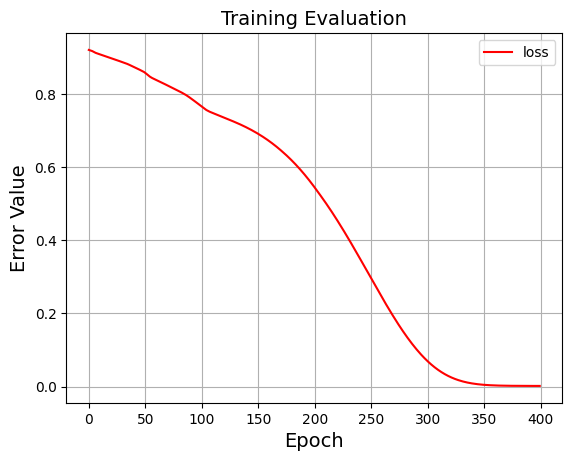

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

0.9308885754583921

In [15]:
model_ext = NeuralNetwork(21, 2)

learning_rate = 0.00001
loss_fn = nn.MSELoss()
batch_size = 1000
optimizer = optim.Adam(model_ext.parameters(), lr=learning_rate)
x_train_ext = x_train_ext.clone().detach()
y_train_ext = y_train_ext.clone().detach()
custom_dataset_ext = MyCustomDataset(x=x_train_ext, y=y_train_ext)

train_loader_ext = DataLoader(
    custom_dataset_ext,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

losses = []
epochs = 400

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn_eval(
        train_loader_ext,
        model_ext,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model_ext.state_dict() }

    torch.save(state, "model_annthyroid_ext.pth")
    
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

y_pred = one_hot_encoding(model_ext.forward(x_test))
accuracy_test(y_test, y_pred)

In [13]:
y_pred

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]])